In [1]:
import yasa
import mne
import os
import scipy
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
#import entropy as ent
import seaborn as sns
from matplotlib import mlab as mlab
import matplotlib.gridspec as gs


In [6]:
# Construct the relative path to the "Data" folder
data_folder_path = os.path.join("..", "..", "Data")

# Get the current working directory
current_path = os.getcwd()

# Check if the current directory ends with the "Data" folder
if not current_path.endswith("Data"):
    # Change the current working directory to the "Data" folder, if not already there
    os.chdir(data_folder_path)
    print(f"Changed directory to: {os.getcwd()}")
else:
    print("Already in the 'Data' directory.")

# Print the current working directory
print("Current Working Directory:", os.getcwd())

Already in the 'Data' directory.
Current Working Directory: g:\My Drive\Dissertation Sleep\Sleep_Analysis\Data


In [7]:
# Read the header information to identify channels and their sampling frequencies
info = mne.io.read_raw_edf("test12_Wednesday_05_ALL_PROCESSED.edf", preload=False).info

# Print the channel information
print(info)

# Identify channels and their corresponding sampling frequencies
channels_info = info['chs']
sampling_freq_map = {}

Extracting EDF parameters from g:\My Drive\Dissertation Sleep\Sleep_Analysis\Data\test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 16 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 08:21:02 UTC
 nchan: 16
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>


### Load in data

In [ ]:
### SKIP FOR NOW -- FIGURE OUT HOW TO DO THIS ELEGANTLY
# For when want to load in all data
# List of seal IDs
seals = ["test12_Wednesday", 
         "test20_SnoozySuzy", 
         "test21_DozyDaisy",
         "test23_AshyAshley",
         "test24_BerthaBeauty",
         "test25_ComaCourtney",
         "test26_DreamyDenise",
         "test30_ExhaustedEllie",
         "test31_FatiguedFiona",
         "test32_GoodnightGerty",
         "test33_HypoactiveHeidi",
         "test34_IndolentIzzy",
         "test35_JauntingJuliette"]

# Dictionary to hold concatenated raw data for each seal
all_seals_data = {}

for seal in seals:
    # Create a pattern for the current seal
    pattern = f"{seal}_05_DAY*_PROCESSED.edf"
    edf_files = sorted(glob.glob(pattern))
    
    # Initialize a list to hold the raw objects for the current seal
    raws = []
    
    for file in edf_files:
        # Read the file without preloading data
        raw = mne.io.read_raw_edf(file, preload=False)
        
        # Preload data in chunks and concatenate
        data, times = raw[:]  # This reads the data into memory; use chunks if necessary
        raws.append(data)
    
    # Concatenate data along the second axis (time)
    if raws:  # Only proceed if the list is not empty
        concatenated_data = np.concatenate(raws, axis=1)
        
        # Use the info from the first file for the new RawArray
        info = mne.io.read_raw_edf(edf_files[0], preload=False).info
        all_seals_data[seal] = mne.io.RawArray(concatenated_data, info)

# Now, all_seals_data contains a Raw object for each seal with their concatenated data

In [17]:
# Load the EDF file, excluding the EOGs and EKG channels
raw = mne.io.read_raw_edf("test12_Wednesday_05_DAY1_PROCESSED.edf", preload=False)
# raw.resample(100)                      # Downsample the data to 100 Hz
# raw.filter(0.1, 40)                    # Apply a bandpass filter from 0.1 to 40 Hz
# raw.pick_channels(['C4-A1', 'C3-A2'])  # Select a subset of EEG channels
raw # Outputs summary data about file

# Inspect Data
print(raw.info)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])

Extracting EDF parameters from g:\My Drive\Dissertation Sleep\Sleep_Analysis\Data\test12_Wednesday_05_DAY1_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: ECG_Raw_Ch1, ECG_ICA2, LEOG_Pruned_Ch2, LEMG_Pruned_Ch4, ...
 chs: 18 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2019-10-25 14:45:22 UTC
 nchan: 18
 projs: []
 sfreq: 500.0 Hz
 subject_info: 1 item (dict)
>
The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure', 'MagX', 'MagY']
The sampling frequency is: 500.0


In [18]:
# Load labeled data
# Path to CSV with scored data
file_path = 'test12_Wednesday_06_Hypnogram_JKB_1Hz.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

      Sleep.Code  Sleep.Num  Seconds               R.Time Resp.Code  Resp.Num  \
0  Active Waking          1      0.0  2019-10-25 14:45:22    Eupnea         2   
1  Active Waking          1      1.0  2019-10-25 14:45:23    Eupnea         2   
2  Active Waking          1      2.0  2019-10-25 14:45:24    Eupnea         2   
3  Active Waking          1      3.0  2019-10-25 14:45:25    Eupnea         2   
4  Active Waking          1      4.0  2019-10-25 14:45:26    Eupnea         2   

  Water.Code  Water.Num  Water.sec        Date                 Time  Hour  \
0       LAND          0          0  2019-10-25  2000-01-01 14:45:22    14   
1       LAND          0          1  2019-10-25  2000-01-01 14:45:23    14   
2       LAND          0          2  2019-10-25  2000-01-01 14:45:24    14   
3       LAND          0          3  2019-10-25  2000-01-01 14:45:25    14   
4       LAND          0          4  2019-10-25  2000-01-01 14:45:26    14   

             SealID          Recording.ID       ID

In [19]:
# Rename channels (replace spaces if any)
channel_renaming_dict = {name: name.replace(' ', '_') for name in raw.ch_names}
raw.rename_channels(channel_renaming_dict)
print('The channels are:', raw.ch_names)

# ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 
# 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure']

# Assuming 'raw' is your Raw object from MNE
channel_types = {}

for ch in raw.ch_names:
    if ch.startswith('ECG'):
        channel_types[ch] = 'ecg'
    elif ch.startswith(('LEOG', 'REOG')):
        channel_types[ch] = 'eog'
    elif ch.startswith(('LEMG', 'REMG')):
        channel_types[ch] = 'emg'
    elif ch.startswith(('LEEG', 'REEG')):
        channel_types[ch] = 'eeg'
    elif ch in ['pitch', 'roll', 'heading']:
        channel_types[ch] = 'resp'
    elif ch in ['GyrZ', 'MagZ', 'ODBA']:
        channel_types[ch] = 'syst'
    elif ch in ['Pressure']:
        channel_types[ch] = 'misc'
    elif ch == 'Heart_Rate':
        channel_types[ch] = 'bio'

# Now set the channel types
raw.set_channel_types(channel_types)

The channels are: ['ECG_Raw_Ch1', 'ECG_ICA2', 'LEOG_Pruned_Ch2', 'LEMG_Pruned_Ch4', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'GyrZ', 'MagZ', 'ODBA', 'Pressure', 'MagX', 'MagY']


C:\Users\Jessie\AppData\Local\Temp\ipykernel_19988\214424503.py:31: RuntimeWarning: The unit for channel(s) GyrZ, MagZ, ODBA, Pressure has changed from V to NA.
  raw.set_channel_types(channel_types)


Measurement date,"October 25, 2019 14:45:22 GMT"
Experimenter,Unknown
Participant,test12_Wednesday
Digitized points,Not available
Good channels,"2 ECG, 1 EOG, 1 EMG, 7 EEG, 3 RESP, 3 SYST, 1 misc"
Bad channels,None
EOG channels,LEOG_Pruned_Ch2
ECG channels,"ECG_Raw_Ch1, ECG_ICA2"
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
['LEOG_Pruned_Ch2', 'REEG2_Pruned_Ch7', 'LEEG3_Pruned_Ch8', 'REEG2_Raw_Ch7', 'LEEG3_Raw_Ch8', 'EEG_ICA5', 'pitch', 'roll', 'heading', 'Pressure', 'MagX', 'MagY']
<RawEDF | test12_Wednesday_05_DAY1_PROCESSED.edf, 18 x 25001 (50.0 s), ~23 kB, data not loaded>
Using matplotlib as 2D backend.


C:\Users\Jessie\AppData\Local\Temp\ipykernel_19988\933900184.py:12: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  mne.viz.plot_raw(raw_selection)
C:\Users\Jessie\AppData\Local\Temp\ipykernel_19988\933900184.py:12: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  mne.viz.plot_raw(raw_selection)


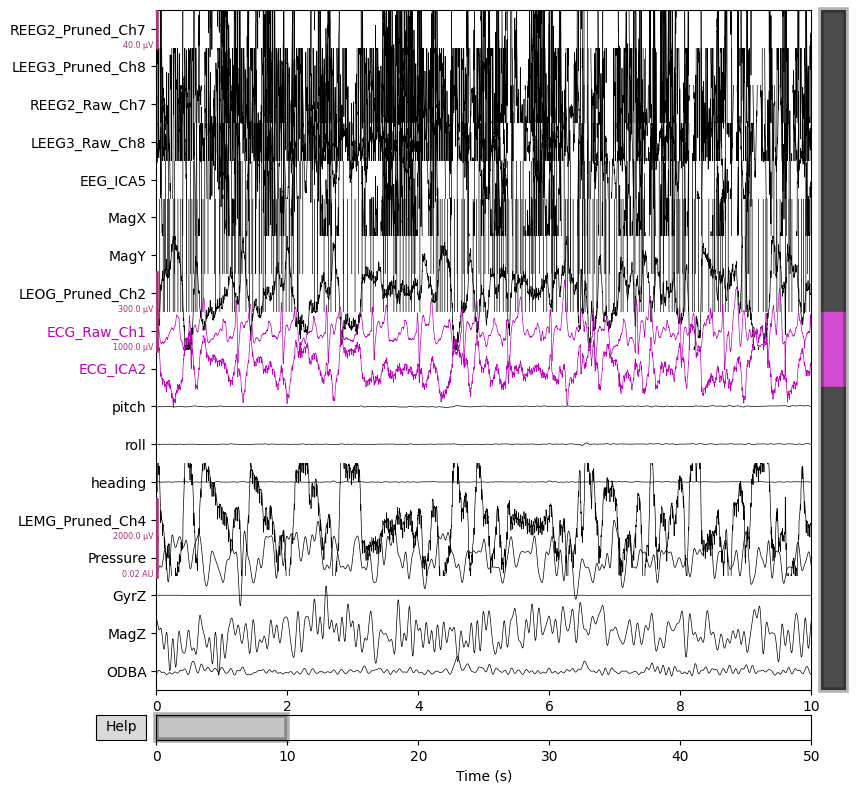

C:\Users\Jessie\AppData\Local\Temp\ipykernel_19988\933900184.py:13: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  mne.viz.plot_raw(raw)
C:\Users\Jessie\AppData\Local\Temp\ipykernel_19988\933900184.py:13: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  mne.viz.plot_raw(raw)


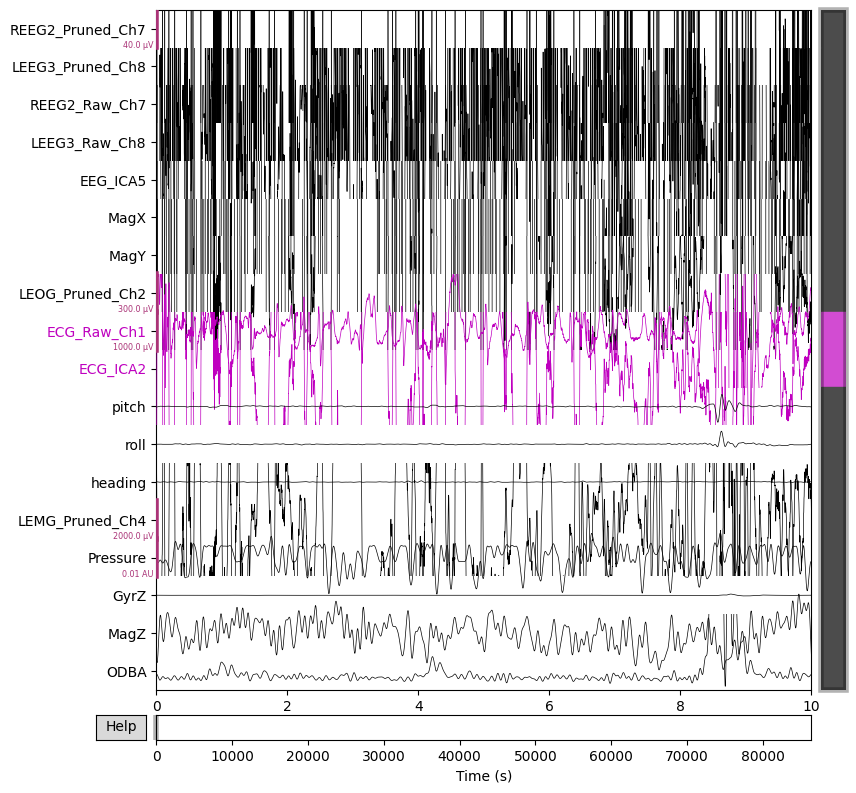

ValueError: picks (['LEEG3', 'REEG4']) could not be interpreted as channel names (no channel "['LEEG3', 'REEG4']"), channel types (no type "LEEG3" present), or a generic type (just "all" or "data")

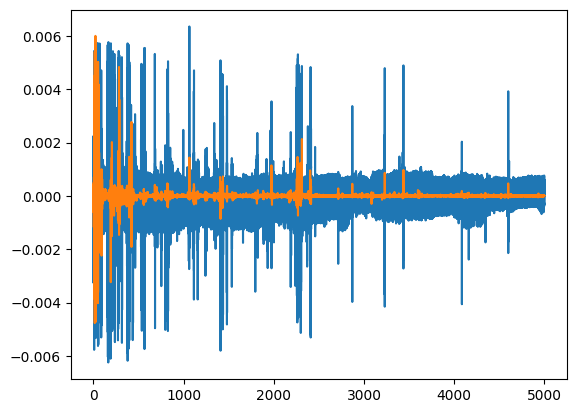

In [20]:


print(raw.copy().pick_types(eeg=True, eog=True, ecog=True, bio=True, resp=True, misc=True).ch_names)

# Generating channel indices to subset data with
# subset_index1 = mne.pick_channels(raw.ch_names, include=[], exclude=['Accel_X','Accel_Z','Illum_(lux)','Pressure_(bars)', 'Temp_(C)'])
# subset_index2 = mne.pick_types(raw.info, eeg=True, eog=True, emg=True, ecg=True)

#Cropping data
raw_selection = raw.copy().crop(tmin=100, tmax=150)
print(raw_selection)

#Preliminary 10s plot of raw data
mne.viz.plot_raw(raw_selection)
mne.viz.plot_raw(raw)

# Plotting the first 50 seconds of the first channel's electrophysiological data
Fs = raw.info['sfreq']  # the sampling frequency or 500
start_stop_seconds = np.array([0, 5000])
start_sample, stop_sample = (start_stop_seconds * Fs).astype(int)
channel_index = 0
ECG_selection = raw[channel_index, start_sample:stop_sample]
LEEG3_selection = raw[7, start_sample:stop_sample] #LEEG3 is stored in column 7
REEG4_selection = raw[8, start_sample:stop_sample] #REEG4 is stored in column 8
# Time data in sec is stored in column 0 and data is stored in column 1 (2nd)
plt.plot(ECG_selection[1], ECG_selection[0].T)
plt.plot(LEEG3_selection[1], LEEG3_selection[0].T) #plots on top of previous plot with same y axis

# Plotting data with channel names
channel_names = ['LEEG3', 'REEG4']
two_eeg_chans = raw[channel_names, start_sample:stop_sample]
y_offset = np.array([1e-4, 0])  # just enough to separate the channel traces
x = two_eeg_chans[1]
y = two_eeg_chans[0].T + y_offset
lines = plt.plot(x, y)
plt.legend(lines, channel_names)


In [22]:
# Plotting spectrogram for first 50 seconds of first channel 
NFFT = 1024       # the length of the windowing segments
spectrum1, freqs1, bins = mlab.specgram(LEEG3_selection[0][0], NFFT=NFFT, Fs=Fs, noverlap=900)
spectrum2, freqs2, bins = mlab.specgram(REEG4_selection[0][0], NFFT=NFFT, Fs=Fs, noverlap=900)

# Only run for [0,5000]
min_val = 5 * np.log10(min(spectrum1.min(), spectrum2.min()))
max_val = 15.5 * np.log10(min(spectrum1.max(), spectrum2.max()))

start_stop_seconds = np.array([0,5000])
start_sample, stop_sample = (start_stop_seconds * Fs).astype(int)

cmap = plt.get_cmap('magma')
cmap.set_under(color='k', alpha=None)

sns.set_style(style='white')

gs0 = gs.GridSpec(6,2, width_ratios=[10,0.1])
fig = plt.figure(figsize=(15,15), dpi=600)
ax0 = fig.add_subplot(gs0[2:4,0]) # Adding space for raw signals at the top
ax1 = fig.add_subplot(gs0[4,0]) # Adding space for first spectrogram
ax2 = fig.add_subplot(gs0[5,0]) # Adding space for second spectrogram
ax3 = fig.add_subplot(gs0[1,0]) # Adding space for heart rate plotting
ax4 = fig.add_subplot(gs0[0,0]) # Adding space for Acc plotting for breaths
cax = fig.add_subplot(gs0[4:6,1])

#Raw EEG Signals plotted
EEG_names = [ch_name for ch_name, ch_type in zip(raw.info['ch_names'], raw.get_channel_types()) if ch_type == 'eeg']
EEG_chans = raw[EEG_names, start_sample:stop_sample]
y_offset = np.array([3e-4, 2e-4, 1e-4, 0])  # just enough to separate the channel traces
y = EEG_chans[0].T + y_offset
ax0.plot(EEG_chans[1], EEG_chans[0].T + y_offset, ['#008000','#001000','#003000','#008000'])
y_ax0 = ax0.axes.get_yaxis()
y_ax0.set_visible(False)
ax0.set_ylabel('R EEG   L EEG   L EMG   L EOG')
ax0.set_xlim(start_stop_seconds)
ax0.set_ylim([-0.0001,0.0004])




C:\Users\Jessie\AppData\Local\Temp\ipykernel_19988\4107849872.py:29: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  EEG_chans = raw[EEG_names, start_sample:stop_sample]


ValueError: operands could not be broadcast together with shapes (2500000,7) (4,) 

In [ ]:
#Heart Rate Signals plotted
HR = raw['Heart_Rate', start_sample:stop_sample]
ax3.plot(HR[1], HR[0].T)
ax3.set_ylabel('Heart Rate (bpm)')
ax3.set_xlim(start_stop_seconds)

#Accelerometer Signals plotted
Acc_names = ['Accel_X', 'Accel_Y', 'Accel_Z']
Acc = raw[Acc_names, start_sample:stop_sample]
ax4.plot(Acc[1], Acc[0].T)
ax4.set_ylabel('Acceleration (G)')
ax4.set_xlim(start_stop_seconds)

#Plot first spectrogram of LEEG3 (Left Parietal EEG)
spectrum1, freqs1, bins1, im1 = ax1.specgram(LEEG3_selection[0][0], NFFT=NFFT, Fs=Fs, noverlap=900, cmap=cmap, vmin=min_val, vmax=max_val)
ax1.set_ylabel('L EEG (Hz)')
ax1.set_ylim([0, 15])
ax1.set_xlim(start_stop_seconds)
x_ax1 = ax1.axes.get_xaxis()
x_ax1.set_visible(False)

#Plot second spectrogram of REEG4 (Right Parietal EEG)
spectrum2, freqs2, bins2, im2 = ax2.specgram(REEG4_selection[0][0], NFFT=NFFT, Fs=Fs, noverlap=900, cmap=cmap, vmin=min_val, vmax=max_val)
# ax2.set(title='R Parietal EEG')
ax2.set_ylabel('R EEG (Hz)')
ax2.set_ylim([0, 15])
ax2.set_xlabel('Time (seconds)')
ax2.set_xlim(start_stop_seconds)
fig.colorbar(im1, cax=cax)

fig.tight_layout()

In [ ]:

#SOMETHINGS NOT WORKING HERE.. 

# Trying with YASA and same issue:
    
yasa.plot_spectrogram(LEEG3_selection[0][0],Fs)